In [21]:
#import statements
import warnings
warnings.filterwarnings('ignore')
import os
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
import cv2
import numpy as np
import pandas as pd
np.random.seed(42)

import sys
from matplotlib import pyplot
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras import applications
from tensorflow.keras.applications import InceptionV3
import tensorflow as tf
import matplotlib.pyplot as plt

In [47]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

In [104]:
# function to load train data
def load_train_data(img_height, img_width):

    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                            samplewise_center = True,
                                                            samplewise_std_normalization = True,
                                                            validation_split = 0.2
                                                            ,preprocessing_function = data_augment
                                                             )

    train_filenames = os.listdir("/kaggle/input/petfinder-pawpularity-score/train")
    train_df = pd.DataFrame({'filename': train_filenames})
    train_df['Id'] = train_df['filename'].str.replace('.jpg', '')
    train_df_tabular = pd.read_csv('/kaggle/input/petfinder-pawpularity-score/train.csv')
    train_df = train_df.merge(train_df_tabular, on="Id")


    train_it = datagen.flow_from_dataframe(train_df, "/kaggle/input/petfinder-pawpularity-score/train", 
            x_col='filename', y_col='Pawpularity', subset='training',
            target_size=(img_height, img_width), 
            class_mode='raw',
            batch_size=24,
            shuffle=False # not to shuffle the given data
        )
    
    validate_it = datagen.flow_from_dataframe(train_df, "/kaggle/input/petfinder-pawpularity-score/train", 
            x_col='filename', y_col='Pawpularity', subset='validation',
            target_size=(img_height, img_width), 
            class_mode='raw',
            batch_size=24,
            shuffle=False # not to shuffle the given data
        )
    
    return train_it, validate_it

# function to load test data
def load_test_data(img_height, img_width):

    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                validation_split = 0.2,
                                preprocessing_function = data_augment)
    
    test_filenames = os.listdir("/kaggle/input/petfinder-pawpularity-score/test")
    test_df = pd.DataFrame({'filename': test_filenames})

    test_it = datagen.flow_from_dataframe(test_df, "/kaggle/input/petfinder-pawpularity-score/test", 
            x_col='filename', y_col=None,
            target_size=(img_height, img_width), 
            class_mode=None,
            batch_size=8,
            shuffle=False # not to shuffle the given data
        )
    
    return test_it

In [105]:
IMAGE_SIZE = 224

train_gen, valid_gen = load_train_data(IMAGE_SIZE, IMAGE_SIZE)
test_gen = load_test_data(IMAGE_SIZE, IMAGE_SIZE)

Found 7930 validated image filenames.
Found 1982 validated image filenames.
Found 8 validated image filenames.


In [85]:
!pip install --quiet vit-keras

from vit_keras import vit

In [114]:
vit_model = vit.vit_b16(
        image_size = IMAGE_SIZE,
        activation = 'linear',
        pretrained = True,
        include_top = False,
        pretrained_top = False
)

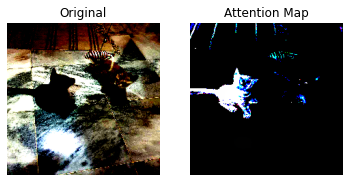

In [113]:
from vit_keras import visualize

x = train_gen.next()
image = x[0][23]

attention_map = visualize.attention_map(model = vit_model, image = image)

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols = 2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(image)
_ = ax2.imshow(attention_map)

In [115]:
import tensorflow_addons as tfa

model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1, 'linear')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit-b16 (Functional)         (None, 768)               85798656  
_________________________________________________________________
flatten_2 (Flatten)          (None, 768)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 768)               3072      
_________________________________________________________________
dense_2 (Dense)              (None, 11)                8459      
_________________________________________________________________
batch_normalization_4 (Batch (None, 11)                44        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 12        
Total params: 85,810,243
Trainable params: 85,808,685
Non-trainable params: 1,558
________________________________

In [ ]:
learning_rate = 1e-4
EPOCHS = 15

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = 'mse', 
              metrics = tf.keras.metrics.RootMeanSquaredError())

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'mse',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'mse',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'mse', 
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]

model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS
          ,callbacks = callbacks
         )

model.save('model.h5', save_weights_only = True)

Epoch 1/15
330/330 [==============================] - 467s 1s/step - loss: 1851.9274 - root_mean_squared_error: 43.0340 - val_loss: 1750.4581 - val_root_mean_squared_error: 41.8385
Epoch 2/15
330/330 [==============================] - 407s 1s/step - loss: 1822.1581 - root_mean_squared_error: 42.6867 - val_loss: 1831.0360 - val_root_mean_squared_error: 42.7906
Epoch 3/15
330/330 [==============================] - 407s 1s/step - loss: 1789.5385 - root_mean_squared_error: 42.3029 - val_loss: 1719.8292 - val_root_mean_squared_error: 41.4708
Epoch 4/15
330/330 [==============================] - 407s 1s/step - loss: 1755.2616 - root_mean_squared_error: 41.8958 - val_loss: 1830.1737 - val_root_mean_squared_error: 42.7805
Epoch 5/15
330/330 [==============================] - 405s 1s/step - loss: 1723.5645 - root_mean_squared_error: 41.5158 - val_loss: 1757.0841 - val_root_mean_squared_error: 41.9176
Epoch 6/15
330/330 [==============================] - 407s 1s/step - loss: 1687.3414 - root_mea

# Data using method 2

In [ ]:
FILE_PATH = '/kaggle/input/petfinder-pawpularity-score/train/'
file_names = []

for dirpath, dirs, files in os.walk(FILE_PATH): 
    for filename in files:
        file_names.append(filename)

images_df = pd.DataFrame(file_names, columns = ['Image name'])

images_df['Id'] = images_df.applymap(lambda x: x.split('.')[0])

train_table = pd.read_csv('/kaggle/input/petfinder-pawpularity-score/train.csv')
paw_merge = images_df.merge(train_table, on = 'Id')

X_train, X_val = train_test_split(paw_merge, test_size=0.1,  random_state=69)
X_train = X_train.reset_index()
X_val = X_val.reset_index()

train_data = X_train['Image name'].map(lambda name: '/kaggle/input/petfinder-pawpularity-score/train/' + name).to_list()
train_label = X_train['Pawpularity'].to_list()

val_data = X_val['Image name'].map(lambda name: '/kaggle/input/petfinder-pawpularity-score/train/' + name).to_list()
val_label = X_val['Pawpularity'].to_list()

In [ ]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [img_size, img_size])

  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

In [ ]:
ds_train = tf.data.Dataset.from_tensor_slices((train_data,train_label))
ds_val = tf.data.Dataset.from_tensor_slices((val_data,val_label))

def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), tf.one_hot(label, 2)

ds_train = ds_train.map(load_and_preprocess_from_path_label)
ds_val = ds_val.map(load_and_preprocess_from_path_label)

print('train dataset:',len(ds_train),'validation dataset:',len(ds_val))

In [ ]:
ds_train = ds_train.shuffle(buffer_size=2000)
ds_batch_train = ds_train.batch(batch_size=batch_size)
ds_batch_train = ds_batch_train.prefetch(tf.data.AUTOTUNE)
ds_batch_val = ds_val.batch(batch_size=batch_size, drop_remainder=False)

In [ ]:
history = model.fit(ds_batch_train, epochs=epochs,
                            validation_data=ds_batch_val,batch_size=batch_size,
                    shuffle=True, verbose=1)